# SOI1010 Machine Learning II - Assignment #2
*   **Name**: Dongmin Kim
*   **Dep**: Automotive Enginnering
*   **ID**: 2021048140
*   **Assigned**: Oct. 20, 2025
*   **Due**: Nov. 5, 2025



 # Problem #1: Binary Classification via soft-margin SVM on CIFAR-10

(a) Load CIFAR-10 dataset

In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets

torch.manual_seed(0)

trainset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
    )
testset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
    )

100%|██████████| 170M/170M [00:04<00:00, 40.8MB/s]


(b) Visualize at least one image for each class

In [2]:
# CIFAR-10 dataset have 10 classes
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is available — using GPU")
else:
    device = torch.device("cpu")
    print("cuda not available — using CPU")

print('cuda is available' if torch.cuda.is_available() else 'Not available')
print('trainset', trainset.data.shape)
print('testset', testset.data.shape)
print('Numbers of classes: ', len(trainset.classes))
print('Name of classes: ', trainset.classes)

cuda is available — using GPU
cuda is available
trainset (50000, 32, 32, 3)
testset (10000, 32, 32, 3)
Numbers of classes:  10
Name of classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


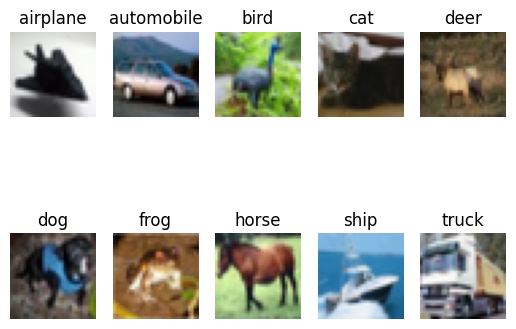

In [3]:
import matplotlib.pyplot as plt

first_idx = {}
for idx in range(len(trainset)):
    _, label = trainset[idx]
    if label not in first_idx:
        first_idx[label] = idx
    if len(first_idx) == len(trainset.classes):
        break

fig, axes = plt.subplots(2,5)

for i in range(2):
    for j in range(5):
        key = 5*i + j
        img, label = trainset[first_idx[key]]
        # img: (C,H,W)
        # matplotlib using (H,W,C)
        img = img.permute(1, 2, 0).numpy()
        axes[i][j].imshow(img)
        axes[i][j].set_title(trainset.classes[label])
        axes[i][j].axis("off")

plt.show()

(c) Split the trainset into training set and validation set with 90% : 10% ratio

In [4]:
from torch.utils.data import random_split, DataLoader

n_tot = len(trainset)
n_train = int(n_tot*0.9)
n_val = n_tot - n_train

train, val = random_split(trainset,[n_train, n_val], generator=torch.Generator().manual_seed(0))

print("train: ", len(train))
print("val: ", len(val))
print("test: ", len(testset))



# Using DataLoader for Batch
batch_size = 64

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True)
val_loader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=False)
test_loader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False)

train:  45000
val:  5000
test:  10000


(d) Choose any two classes. Then, make a SVM classifier (implement a loss function yourself. Do not use PyTorch implementations of loss functions.) and its training/validation/evaluation code to perform binary classification between those two classes.

In [5]:
from torch.utils.data import Subset

# Choose two classes {3: cat, 5: dog}
pos, neg = 3, 5

def two_class(ds, classes=(pos, neg)):
    if isinstance(ds, Subset):
        base = ds.dataset
        idx = ds.indices
    else:
        base = ds
        idx = range(len(base))

    targets = np.array(base.targets)
    keep = [i for i in idx if targets[i] in classes]
    return Subset(base, keep)


class binary(torch.utils.data.Dataset):
    def __init__ (self, subset, pos=pos, neg=neg, flatten=True):
        self.subset = subset
        self.pos = pos
        self.neg = neg
        self.flatten = flatten
    def __len__(self):
        return(len(self.subset))
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if y==self.pos:
            y = 1
        else:
            y = -1
        if self.flatten:
            x = x.reshape(-1)
        return x, torch.tensor(y, dtype=torch.float32)

In [6]:
train_SVM = two_class(train, (pos, neg))
val_SVM = two_class(val, (pos, neg))
test_SVM = two_class(testset,(pos, neg))

train_b = binary(train_SVM)
val_b = binary(val_SVM)
test_b = binary(test_SVM)

# Val, Test: shuffle=Flase
train_DL = DataLoader(train_b, batch_size = 64, shuffle=True)
val_DL = DataLoader(val_b, batch_size = 64, shuffle=False)
test_DL = DataLoader(test_b, batch_size = 64, shuffle=False)

In [7]:
#################
# Hyperparamenter:
# Learning Rate
# Weight Decay
# Epochs
#################

class SVM:
    def __init__(self, input_dim, lr, weight_decay, epochs, device=device):
        self.device = device
        self.w = torch.zeros(input_dim, device=self.device)
        self.b = torch.zeros(1, device=self.device)
        self.lr = lr
        self.epochs = epochs
        self.weight_decay = weight_decay

    def forward(self, x):
        y_hat = x @ self.w + self.b
        return y_hat

    def loss(self, x, y):
        f = self.forward(x)
        margins = 1 - y*f
        hinge = torch.clamp(margins, min=0)
        loss = hinge.mean() + 0.5 * self.weight_decay * (self.w @ self.w)
        return loss, margins

    def backward(self, x, y, margins):
        active = (margins > 0).float()
        B = y.size(0)
        active_mask = (active * y).unsqueeze(1)
        grad_w = -(x*active_mask).sum(dim=0) / B + self.weight_decay * self.w
        grad_b = -(active * y).sum() / B
        return grad_w, grad_b

    def step(self, grad_w, grad_b):
        self.w -= self.lr * grad_w
        self.b -= self.lr * grad_b

    def fit(self, train_loader, val_loader=None):
        for epoch in range(1, self.epochs +1):
            total_loss = 0
            for x, y in train_loader:
                x = x.to(self.device)
                y = y.to(self.device)

                loss, margins = self.loss(x,y)
                total_loss += loss.item()

                grad_w, grad_b = self.backward(x, y, margins)

                self.step(grad_w, grad_b)

            if val_loader:
                val_acc = self.evaluate(val_loader)
            else:
                0.0

    def evaluate(self, loader):
        correct, total = 0, 0
        for x, y in loader:
            x = x.to(self.device)
            y = y.to(self.device)
            s = self.forward(x)
            pred = torch.sign(s)
            correct += (pred == y).sum().item()
            total += y.size(0)
        return correct / total


    def predict(self, x):
        s = self.forward(x.to(self.device))
        return torch.sign(s)

(e) Train for 10 epochs with batch size 64

In [8]:
for x, y in train_DL:
    print(x.shape, y.shape)
    break

input_dim = x.shape[1]
print('input dimension: ', input_dim)

svm = SVM(input_dim, lr=1e-3, weight_decay=1e-4, epochs=10)
svm.fit(train_DL, val_DL)
val_acc = svm.evaluate(val_DL)
test_acc = svm.evaluate(test_DL)
print(f"Val Acc: {val_acc*100:.2f}%")
print(f"Test Acc: {test_acc*100:.2f}%")

torch.Size([64, 3072]) torch.Size([64])
input dimension:  3072
Val Acc: 57.96%
Test Acc: 59.00%


(f) Perform data normalization.

In [9]:
torch.manual_seed(0)

trainset_2 = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
    )
testset_2 = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
    )

In [10]:
def mean_std(ds, batch_size=256):
    n = 0
    mean = torch.zeros(3)
    M2   = torch.zeros(3)
    # x: [B, C, H, W]
    for x, _ in ds:
        b = 1
        n_new = n + b
        # (C,)
        batch_mean = x.mean(dim=[1,2])
        delta = batch_mean - mean
        mean = mean + delta * (b / n_new)
        # (C,)
        var_batch = x.var(dim=[1,2], unbiased=False)
        M2 = M2 + var_batch * b + (delta**2) * n * b / n_new
        n = n_new
    var = M2 / n
    std = torch.sqrt(var + 1e-8)
    return mean, std

In [11]:
mean_train, std_train = mean_std(trainset)

print('trainsets mean and train: ', mean_train, std_train)

tr_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train, std=std_train)
])


trainset_norm = datasets.CIFAR10(root='./data', train=True,  download=False, transform=tr_norm)
test_normalize  = datasets.CIFAR10(root='./data', train=False, download=False, transform=tr_norm)

tot_norm = len(trainset_norm)
train_norm = int(tot_norm*0.9)
val_norm = tot_norm - train_norm

train_normalize, val_normalize = random_split(trainset_norm,[train_norm, val_norm], generator=torch.Generator().manual_seed(0))
print("train: ", len(train_normalize))
print("val: ", len(val_normalize))
print("test: ", len(test_normalize))

train_SVM_n = two_class(train_normalize, (pos, neg))
val_SVM_n = two_class(val_normalize, (pos, neg))
test_SVM_n = two_class(test_normalize,(pos, neg))

train_b_n = binary(train_SVM_n, pos, neg, flatten=True)
val_b_n = binary(val_SVM_n, pos, neg, flatten=True)
test_b_n = binary(test_SVM_n, pos, neg, flatten=True)

batch_size = 64
train_DL_n = DataLoader(train_b_n, batch_size=batch_size, shuffle=True)
val_DL_n = DataLoader(val_b_n, batch_size=batch_size, shuffle=False)
test_DL_n = DataLoader(test_b_n, batch_size=batch_size, shuffle=False)



trainsets mean and train:  tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])
train:  45000
val:  5000
test:  10000


 (g) Again, train for 10 epochs with batch size 64 after data normalization.

In [12]:
for x, y in train_DL_n:
    print(x.shape, y.shape)
    break

input_dim = x.shape[1]
print('input dimension: ', input_dim)

svm = SVM(input_dim, lr=1e-3, weight_decay=1e-4, epochs=10)
svm.fit(train_DL_n, val_DL_n)
val_acc = svm.evaluate(val_DL_n)
test_acc = svm.evaluate(test_DL_n)
print(f"Val Acc: {val_acc*100:.2f}%")
print(f"Test Acc: {test_acc*100:.2f}%")

torch.Size([64, 3072]) torch.Size([64])
input dimension:  3072
Val Acc: 60.04%
Test Acc: 62.35%


(h) What are the hyperparameters you can tune?
- Learning Rate
- Weight Decay
- Epochs
- Batch Size

 (i) Try to obtain find optimal hyperparameters.

Epoch 01 | Train Loss: 0.8219 | Val Loss: 0.8804
Epoch 02 | Train Loss: 0.8195 | Val Loss: 0.8645
Epoch 03 | Train Loss: 0.8159 | Val Loss: 0.8628
Epoch 04 | Train Loss: 0.8167 | Val Loss: 0.8689
Epoch 05 | Train Loss: 0.8145 | Val Loss: 0.8827
Epoch 06 | Train Loss: 0.8088 | Val Loss: 0.8706
Epoch 07 | Train Loss: 0.8083 | Val Loss: 0.8637
Epoch 08 | Train Loss: 0.8065 | Val Loss: 0.8744
Epoch 09 | Train Loss: 0.8044 | Val Loss: 0.8692
Epoch 10 | Train Loss: 0.8030 | Val Loss: 0.8686


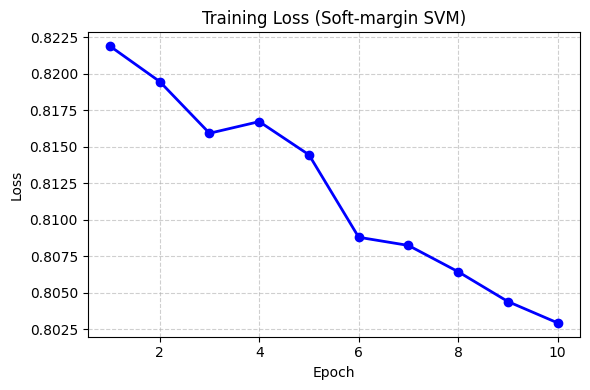

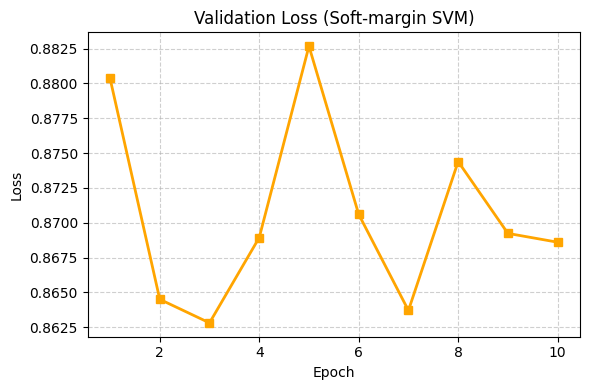

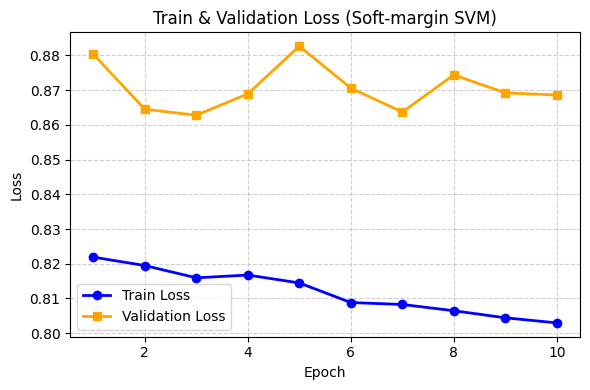

In [13]:
train_losses = []
val_losses = []

for epoch in range(1, svm.epochs + 1):
    total_train_loss = 0.0
    total_val_loss = 0.0

    # Train Loss
    for x, y in train_DL_n:
        x, y = x.to(svm.device), y.to(svm.device)
        loss, margins = svm.loss(x, y)
        total_train_loss += loss.item()
        grad_w, grad_b = svm.backward(x, y, margins)
        svm.step(grad_w, grad_b)

    avg_train_loss = total_train_loss / len(train_DL_n)
    train_losses.append(avg_train_loss)

    # Val Loss
    with torch.no_grad():
        for x_val, y_val in val_DL_n:
            x_val, y_val = x_val.to(svm.device), y_val.to(svm.device)
            val_loss, _ = svm.loss(x_val, y_val)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_DL_n)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


epochs = range(1, len(train_losses) + 1)

# Train Loss
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, marker='o', linewidth=2, color='blue')
plt.title("Training Loss (Soft-margin SVM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("svm_train_loss_only.png", dpi=200)
plt.show()

# Validation Loss
plt.figure(figsize=(6,4))
plt.plot(epochs, val_losses, marker='s', linewidth=2, color='orange')
plt.title("Validation Loss (Soft-margin SVM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("svm_val_loss_only.png", dpi=200)
plt.show()

#  Train + Validation Loss
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, marker='o', linewidth=2, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, marker='s', linewidth=2, label='Validation Loss', color='orange')
plt.title("Train & Validation Loss (Soft-margin SVM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("svm_train_val_loss_combined.png", dpi=200)
plt.show()

In [ ]:
for x, y in train_DL_n:
    print(x.shape, y.shape)
    break

lr_list = [1e-3, 2e-3, 3e-3, 4e-3, 5e-3]
wd_list = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4]

for lr in lr_list:
    for wd in wd_list:
        svm = SVM(x.shape[1], lr, weight_decay=wd, epochs=10)
        svm.fit(train_DL_n, val_DL_n)
        val_acc = svm.evaluate(val_DL_n)
        print(f"Learning Rate: {lr}, Weight Decay: {wd}, Val Acc: {val_acc*100:.2f}%")

torch.Size([64, 3072]) torch.Size([64])
Learning Rate: 0.001, Weight Decay: 0.0001, Val Acc: 58.75%
Learning Rate: 0.001, Weight Decay: 0.0002, Val Acc: 60.44%
Learning Rate: 0.001, Weight Decay: 0.0003, Val Acc: 59.25%
Learning Rate: 0.001, Weight Decay: 0.0004, Val Acc: 60.53%
Learning Rate: 0.001, Weight Decay: 0.0005, Val Acc: 60.04%
Learning Rate: 0.002, Weight Decay: 0.0001, Val Acc: 60.34%
Learning Rate: 0.002, Weight Decay: 0.0002, Val Acc: 59.25%
Learning Rate: 0.002, Weight Decay: 0.0003, Val Acc: 58.36%
Learning Rate: 0.002, Weight Decay: 0.0004, Val Acc: 60.63%
Learning Rate: 0.002, Weight Decay: 0.0005, Val Acc: 60.44%
Learning Rate: 0.003, Weight Decay: 0.0001, Val Acc: 59.84%
Learning Rate: 0.003, Weight Decay: 0.0002, Val Acc: 54.90%
Learning Rate: 0.003, Weight Decay: 0.0003, Val Acc: 58.06%
Learning Rate: 0.003, Weight Decay: 0.0004, Val Acc: 60.24%
Learning Rate: 0.003, Weight Decay: 0.0005, Val Acc: 61.03%
Learning Rate: 0.004, Weight Decay: 0.0001, Val Acc: 60.24%


 (j) What is the final test accuracy?

In [14]:
for x, y in train_DL_n:
    print(x.shape, y.shape)
    break


svm = SVM(x.shape[1], lr=2e-3, weight_decay=5e-4, epochs=10)
svm.fit(train_DL_n, val_DL_n)
val_acc = svm.evaluate(val_DL_n)
test_acc = svm.evaluate(test_DL_n)
print(f"Learning Rate: {2e-3}, Weight Decay: {5e-4}, Val Acc: {val_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")


torch.Size([64, 3072]) torch.Size([64])
Learning Rate: 0.002, Weight Decay: 0.0005, Val Acc: 58.46%, Test Acc: 60.05%


 # Problem #2: Multiclass Classification via multiple one-vs-allsoft-margin SVM on CIFAR10

(a) Perform multiclass classification using multiple one-vs-all soft-margin SVM, using your
 SVM implementation.

In [12]:
class OneVSAll (torch.utils.data.Dataset):
    def __init__(self, subset, pos, flatten=True):
        self.subset = subset
        self.pos = pos
        self.flatten = flatten

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if y==self.pos:
            y = 1
        else:
            y = -1
        if self.flatten:
            x = x.reshape(-1)
        return x, torch.tensor(y, dtype=torch.float32)

In [13]:
class SVM_Mul:
    def __init__(self, input_dim, lr, weight_decay, epochs, device=device):
        self.device = device
        self.w = torch.zeros(input_dim, device=self.device)
        self.b = torch.zeros(1, device=self.device)
        self.lr = lr
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.history = []

    def forward(self, x):
        return x @ self.w + self.b

    def loss(self, x, y):
        f = self.forward(x)
        margins = 1 - y * f
        hinge = torch.clamp(margins, min=0)
        loss = hinge.mean() + 0.5 * self.weight_decay * (self.w @ self.w)
        return loss, margins

    def backward(self, x, y, margins):
        active = (margins > 0).float()
        B = y.size(0)
        active_mask = (active * y).unsqueeze(1)
        grad_w = -(x * active_mask).sum(dim=0) / B + self.weight_decay * self.w
        grad_b = -(active * y).sum() / B
        return grad_w, grad_b

    def step(self, grad_w, grad_b):
        self.w -= self.lr * grad_w
        self.b -= self.lr * grad_b

    def fit(self, train_loader, val_loader=None):
        self.history.clear()
        for epoch in range(1, self.epochs + 1):
            total_loss = 0
            for x, y in train_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                loss, margins = self.loss(x, y)
                total_loss += loss.item()
                grad_w, grad_b = self.backward(x, y, margins)
                self.step(grad_w, grad_b)

            avg_loss = total_loss / len(train_loader)
            self.history.append(avg_loss)

    def evaluate(self, loader):
        correct, total = 0, 0
        for x, y in loader:
            x = x.to(self.device)
            y = y.to(self.device)
            s = self.forward(x)
            pred = torch.sign(s)
            correct += (pred == y).sum().item()
            total += y.size(0)
        return correct / total

    def predict(self, x):
        return torch.sign(self.forward(x.to(self.device)))

In [ ]:
num_classes = 10
batch_size = 64
svm_models = []

for pos in range(num_classes):
    train_pos = OneVSAll(train_normalize, pos, flatten=True)
    val_pos = OneVSAll(val_normalize, pos, flatten=True)

    train_DL = DataLoader(train_pos, batch_size=batch_size, shuffle=True)
    val_DL = DataLoader(val_pos, batch_size=batch_size, shuffle=False)

    svm = SVM_Mul(3*32*32, lr=2e-3, weight_decay=5e-4, epochs=10)
    svm.fit(train_DL, val_DL)

    val_acc = svm.evaluate(val_DL)
    print(f"[Class {pos}] Val Acc: {val_acc*100:.2f}%")
    svm_models.append(svm)

[Class 0] Val Acc: 90.46%
[Class 1] Val Acc: 90.50%
[Class 2] Val Acc: 85.32%
[Class 3] Val Acc: 89.92%
[Class 4] Val Acc: 89.34%
[Class 5] Val Acc: 89.86%
[Class 6] Val Acc: 89.92%
[Class 7] Val Acc: 89.44%
[Class 8] Val Acc: 87.70%
[Class 9] Val Acc: 90.78%


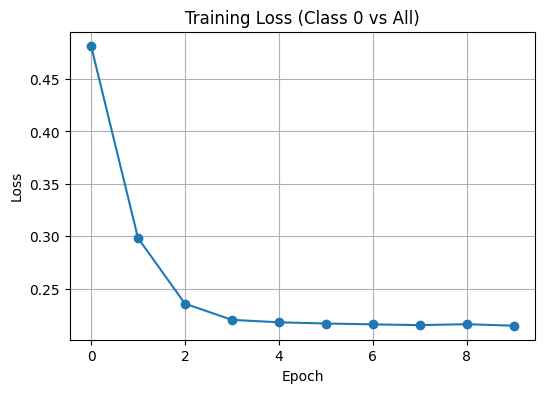

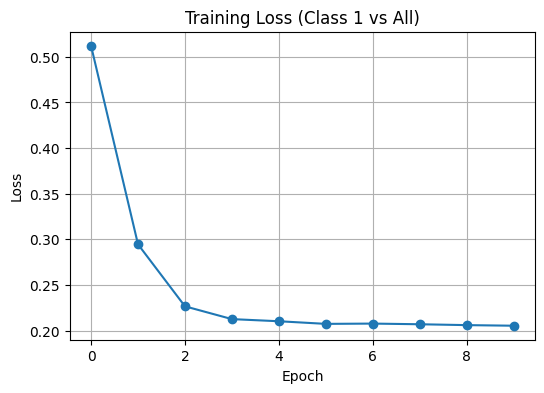

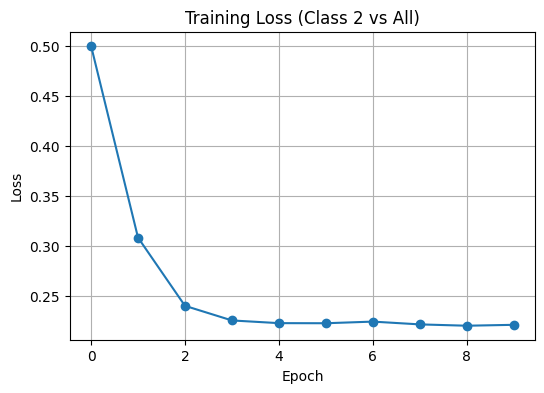

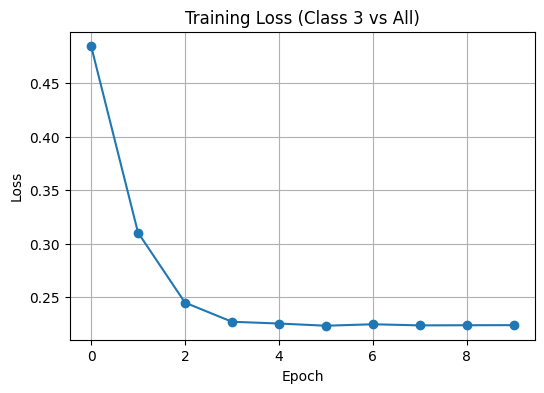

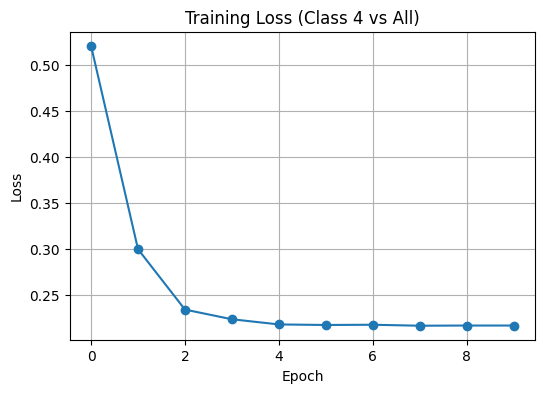

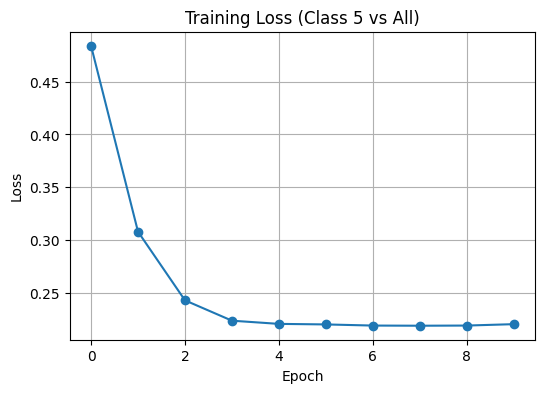

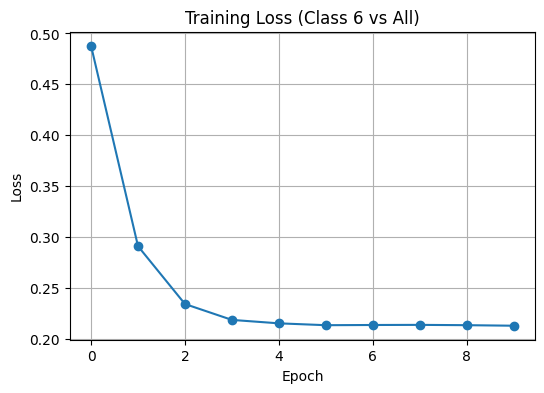

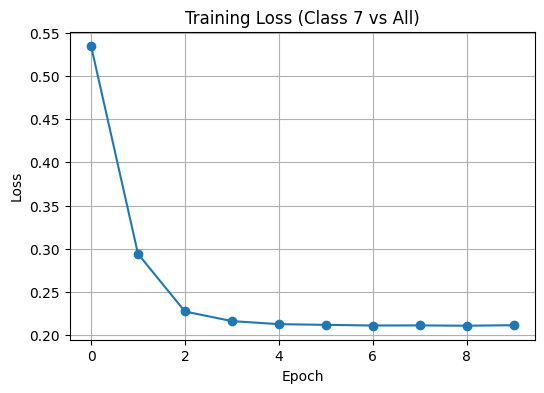

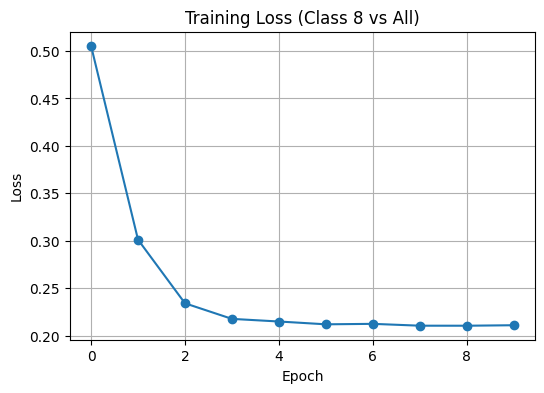

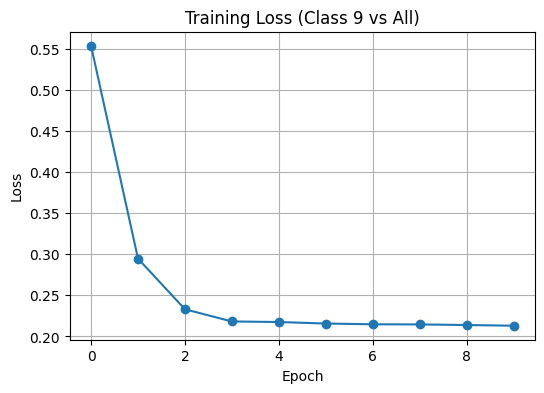

In [ ]:
for i, model in enumerate(svm_models):
    plt.figure(figsize=(6,4))
    plt.plot(model.history, marker='o')
    plt.title(f"Training Loss (Class {i} vs All)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

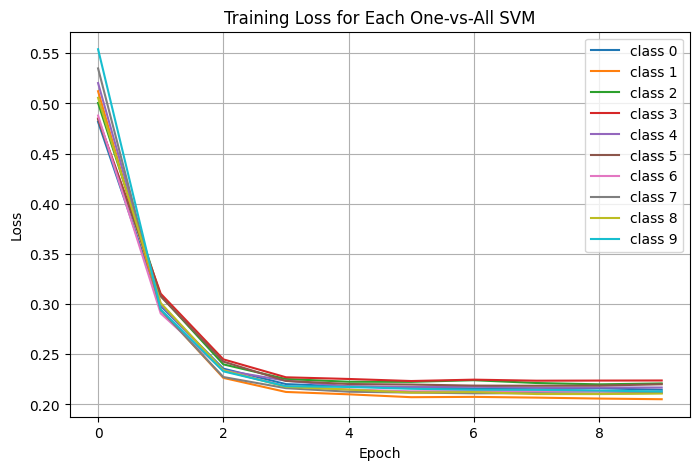

In [ ]:
plt.figure(figsize=(8,5))
for i, model in enumerate(svm_models):
    plt.plot(model.history, label=f"class {i}")
plt.title("Training Loss for Each One-vs-All SVM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

 (b) Perform hyperparameter search for each SVM separately.

In [ ]:
lr_list = [1e-3, 2e-3, 3e-3, 4e-3, 5e-3]
wd_list = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4]
epochs  = 10
batch_size = 64
num_classes = 10
pos = 9

train_pos = OneVSAll(train_normalize, pos, flatten=True)
val_pos = OneVSAll(val_normalize, pos, flatten=True)

train_DL = DataLoader(train_pos, batch_size, shuffle=True)
val_DL = DataLoader(val_pos, batch_size, shuffle=False)

best_val = -1.0
best_hp = None

for lr in lr_list:
    for wd in wd_list:
        svm = SVM_Mul(3*32*32, lr, wd, epochs)
        svm.fit(train_DL, val_DL)
        val_acc = svm.evaluate(val_DL)
        print(f"val acc={val_acc*100:.2f}% | lr={lr} | wd={wd}")

        if val_acc > best_val:
            best_val = val_acc
            best_hp = {"lr": lr, "wd": wd}

print(f"best val acc = {best_val*100:.2f}%  (lr={best_hp['lr']}, wd={best_hp['wd']})")

val acc=90.66% | lr=0.001 | wd=0.0001
val acc=90.66% | lr=0.001 | wd=0.0002
val acc=90.66% | lr=0.001 | wd=0.0003
val acc=90.66% | lr=0.001 | wd=0.0004
val acc=90.66% | lr=0.001 | wd=0.0005
val acc=90.66% | lr=0.002 | wd=0.0001
val acc=90.66% | lr=0.002 | wd=0.0002
val acc=90.66% | lr=0.002 | wd=0.0003
val acc=90.54% | lr=0.002 | wd=0.0004
val acc=90.66% | lr=0.002 | wd=0.0005
val acc=90.64% | lr=0.003 | wd=0.0001
val acc=89.56% | lr=0.003 | wd=0.0002
val acc=90.56% | lr=0.003 | wd=0.0003
val acc=90.58% | lr=0.003 | wd=0.0004
val acc=89.76% | lr=0.003 | wd=0.0005
val acc=86.18% | lr=0.004 | wd=0.0001
val acc=90.88% | lr=0.004 | wd=0.0002
val acc=91.12% | lr=0.004 | wd=0.0003
val acc=90.48% | lr=0.004 | wd=0.0004
val acc=90.78% | lr=0.004 | wd=0.0005
val acc=90.00% | lr=0.005 | wd=0.0001
val acc=90.68% | lr=0.005 | wd=0.0002
val acc=90.36% | lr=0.005 | wd=0.0003
val acc=89.96% | lr=0.005 | wd=0.0004
val acc=78.10% | lr=0.005 | wd=0.0005
best val acc = 91.12%  (lr=0.004, wd=0.0003)


 (c) What is the final test accuracy?

In [45]:
def predict_ova(models, x_batch, device, use_norm=True):
    if x_batch.dim() > 2:
        x_batch = x_batch.view(x_batch.size(0), -1)
    x_batch = x_batch.to(device)

    W, b, norms = [], [], []
    for m in models:
        w = m.w
        if w.dim() == 2 and w.size(1) == 1:
            w = w.view(-1)
        W.append(w)
        b.append(m.b.view(()))
        norms.append(torch.clamp(w.norm(), min=1e-6))

    W = torch.stack(W, dim=1).to(device)
    b = torch.stack(b, dim=0).to(device)
    norms = torch.stack(norms, dim=0).to(device)

    scores = x_batch @ W + b
    if use_norm:
        scores = scores / norms
    return torch.argmax(scores, dim=1)

def evaluate_ova(models, loader, device):
    correct = total = 0
    for x, y in loader:
        preds = predict_ova(models, x, device, use_norm=True)
        correct += (preds.cpu() == y.cpu()).sum().item()
        total   += y.size(0)
    return correct / total

In [38]:
svm_models = []
for pos in range(10):
    train_pos = OneVSAll(train_normalize, pos, flatten=True)
    val_pos = OneVSAll(val_normalize, pos, flatten=True)

    train_DL = DataLoader(train_pos, batch_size=64, shuffle=True)
    val_DL = DataLoader(val_pos, batch_size=64, shuffle=False)

    svm = SVM_Mul(3*32*32, lr=4e-3, weight_decay=3e-4, epochs=10, device=device)
    svm.fit(train_DL, val_DL)
    print(f"Class {pos} | Val Acc: {svm.evaluate(val_DL)*100:.2f}%")
    svm_models.append(svm)

Class 0 | Val Acc: 91.10%
Class 1 | Val Acc: 89.42%
Class 2 | Val Acc: 90.12%
Class 3 | Val Acc: 89.74%
Class 4 | Val Acc: 88.46%
Class 5 | Val Acc: 89.86%
Class 6 | Val Acc: 90.14%
Class 7 | Val Acc: 86.16%
Class 8 | Val Acc: 89.54%
Class 9 | Val Acc: 75.86%


In [46]:
test_DL = DataLoader(test_normalize, batch_size=64, shuffle=False, pin_memory=True)
acc = evaluate_ova(svm_models, test_DL, device)
print(f"test acc: {acc*100:.2f}%")

test acc: 25.42%


 # Problem #3: Multiclass Classification via multinomial/multiclass logistic regression on CIFAR10

(a) Implement your own multinomial/multiclass logistic regression from scratch.

In [20]:
class Multinomial:
    def __init__(self, D, C, lr, wd, epochs, device=device):
        self.device = device
        self.W = torch.zeros(D, C, device=self.device, requires_grad=True)
        self.b = torch.zeros(C, device=self.device, requires_grad=True)
        self.lr = lr
        self.wd = wd
        self.epochs = epochs
        self.history = []

    def forward(self, x):
        return x @ self.W + self.b

    @staticmethod
    def log_softmax(logits, dim=1):
        m = logits.max(dim=dim, keepdim=True).values
        z = logits - m
        logsumexp = m + torch.log(torch.exp(z).sum(dim=dim, keepdim=True))
        return logits - logsumexp

    def loss(self, logits, y):
        ls = self.log_softmax(logits, dim=1)
        return (-ls.gather(1, y.view(-1,1)).squeeze(1)).mean()

    def zero_grad(self):
        if self.W.grad is not None: self.W.grad.zero_()
        if self.b.grad is not None: self.b.grad.zero_()

    def sgd_step(self):
        with torch.no_grad():
            self.W -= self.lr * (self.W.grad + self.wd * self.W)
            self.b -= self.lr * self.b.grad
        self.W.grad.zero_()
        self.b.grad.zero_()

    def fit(self, train_DL, val_DL=None):
        for ep in range(1, self.epochs+1):
            total_loss, n = 0.0, 0
            for x, y in train_DL:
                x, y = x.to(self.device), y.to(self.device)
                if x.dim() > 2:
                    x = x.view(x.size(0), -1)
                logits = self.forward(x)
                loss = self.loss(logits, y)
                loss.backward()
                self.sgd_step()

                total_loss += loss.item() * x.size(0)
                n += x.size(0)

            avg_loss = total_loss / n
            self.history.append(avg_loss)

            if val_DL is not None:
                val_acc = evaluate_lr(self, val_DL, self.device)
                print(f"Epoch {ep:02d} | TrainLoss {avg_loss:.4f} | ValAcc {val_acc*100:.2f}%")
        return self

@torch.no_grad()
def evaluate_lr(model, loader, device=device):
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        preds = model.forward(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

In [24]:
train_DL = DataLoader(train_normalize, batch_size=64, shuffle=True)
val_DL   = DataLoader(val_normalize, batch_size=64, shuffle=False)

model = Multinomial(3*32*32, 10, lr=1e-3, wd=1e-4, epochs=10)
model.fit(train_DL, val_DL)
val_acc  = evaluate_lr(model, val_DL)
print(f"val acc: {val_acc*100:.2f}%")

Epoch 01 | TrainLoss 1.8983 | ValAcc 36.62%
Epoch 02 | TrainLoss 1.8023 | ValAcc 38.84%
Epoch 03 | TrainLoss 1.7736 | ValAcc 39.38%
Epoch 04 | TrainLoss 1.7559 | ValAcc 38.82%
Epoch 05 | TrainLoss 1.7429 | ValAcc 39.82%
Epoch 06 | TrainLoss 1.7331 | ValAcc 39.98%
Epoch 07 | TrainLoss 1.7248 | ValAcc 39.52%
Epoch 08 | TrainLoss 1.7172 | ValAcc 39.88%
Epoch 09 | TrainLoss 1.7106 | ValAcc 39.78%
Epoch 10 | TrainLoss 1.7055 | ValAcc 40.00%
val acc: 40.00%


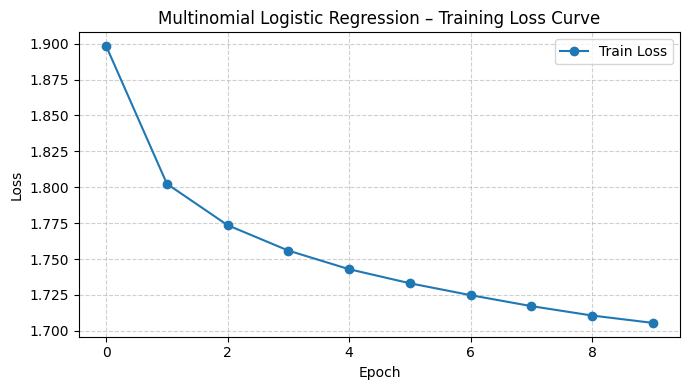

In [27]:
plt.figure(figsize=(7,4))
plt.plot(model.history, marker='o', label='Train Loss')
plt.title("Multinomial Logistic Regression – Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

 (b) Perform hyperparameter search.

In [28]:
lr_list = [1e-3, 2e-3, 3e-3, 4e-3, 5e-3]
wd_list = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4]

best_val = -1.0
best_hp = None

for lr in lr_list:
    for wd in wd_list:
        model = Multinomial(3*32*32, 10, lr=lr, wd=wd, epochs=10)
        model.fit(train_DL, val_DL)
        val_acc  = evaluate_lr(model, val_DL)
        print(f"val acc={val_acc*100:.2f}% | lr={lr} | wd={wd}")

        if val_acc > best_val:
            best_val = val_acc
            best_hp = {"lr": lr, "wd": wd}

Epoch 01 | TrainLoss 1.8975 | ValAcc 36.50%
Epoch 02 | TrainLoss 1.8020 | ValAcc 38.58%
Epoch 03 | TrainLoss 1.7734 | ValAcc 38.86%
Epoch 04 | TrainLoss 1.7563 | ValAcc 38.96%
Epoch 05 | TrainLoss 1.7430 | ValAcc 39.52%
Epoch 06 | TrainLoss 1.7330 | ValAcc 39.02%
Epoch 07 | TrainLoss 1.7244 | ValAcc 39.58%
Epoch 08 | TrainLoss 1.7173 | ValAcc 39.76%
Epoch 09 | TrainLoss 1.7110 | ValAcc 39.46%
Epoch 10 | TrainLoss 1.7058 | ValAcc 40.64%
val acc=40.64% | lr=0.001 | wd=0.0001
Epoch 01 | TrainLoss 1.8988 | ValAcc 36.90%
Epoch 02 | TrainLoss 1.8016 | ValAcc 37.70%
Epoch 03 | TrainLoss 1.7735 | ValAcc 38.04%
Epoch 04 | TrainLoss 1.7558 | ValAcc 38.42%
Epoch 05 | TrainLoss 1.7430 | ValAcc 38.60%
Epoch 06 | TrainLoss 1.7328 | ValAcc 39.98%
Epoch 07 | TrainLoss 1.7250 | ValAcc 39.60%
Epoch 08 | TrainLoss 1.7177 | ValAcc 39.28%
Epoch 09 | TrainLoss 1.7107 | ValAcc 40.52%
Epoch 10 | TrainLoss 1.7060 | ValAcc 40.50%
val acc=40.50% | lr=0.001 | wd=0.0002
Epoch 01 | TrainLoss 1.8982 | ValAcc 37.56%


In [29]:
print(f"best val acc = {best_val*100:.2f}%  (lr={best_hp['lr']}, wd={best_hp['wd']})")

best val acc = 40.64%  (lr=0.001, wd=0.0001)


 (c) What is the final test accuracy?

In [31]:
final_model = Multinomial(3*32*32, 10,
                          lr=best_hp["lr"],
                          wd=best_hp["wd"],
                          epochs=10,
                          device="cuda")
final_model.fit(train_DL, val_DL)
test_DL = DataLoader(test_normalize, batch_size=64, shuffle=False, pin_memory=True)
test_acc = evaluate_lr(final_model, test_DL)

print(f"test acc: {test_acc*100:.2f}%")

Epoch 01 | TrainLoss 1.8977 | ValAcc 36.66%
Epoch 02 | TrainLoss 1.8023 | ValAcc 38.02%
Epoch 03 | TrainLoss 1.7739 | ValAcc 38.34%
Epoch 04 | TrainLoss 1.7561 | ValAcc 38.80%
Epoch 05 | TrainLoss 1.7433 | ValAcc 39.36%
Epoch 06 | TrainLoss 1.7328 | ValAcc 39.96%
Epoch 07 | TrainLoss 1.7244 | ValAcc 40.14%
Epoch 08 | TrainLoss 1.7170 | ValAcc 40.40%
Epoch 09 | TrainLoss 1.7104 | ValAcc 38.96%
Epoch 10 | TrainLoss 1.7056 | ValAcc 40.38%
test acc: 40.80%


 (d) Compare against a model implemented using functions from PyTorch libraries.

In [32]:
import torch.nn as nn

In [33]:
class Implemented(nn.Module):
    def __init__(self, D=3*32*32, C=10):
        super().__init__()
        self.linear = nn.Linear(D, C, bias=True)
    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        return self.linear(x)

@torch.no_grad()
def evaluate_implemented(model, loader, device=device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total


def train_implemented(train_DL, val_DL, best_hp, epochs=10, device=device):
    net = Implemented().to(device)
    crit = nn.CrossEntropyLoss()
    opt  = torch.optim.SGD(net.parameters(),
                           lr=best_hp["lr"],
                           weight_decay=best_hp["wd"],
                           momentum=0.0)

    history = []

    for ep in range(1, epochs+1):
        net.train()
        total_loss, n = 0.0, 0
        for x, y in train_DL:
            x, y = x.to(device), y.to(device)
            logits = net(x)
            loss = crit(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item() * x.size(0)
            n += x.size(0)

        avg_loss = total_loss / n
        history.append(avg_loss)
        if val_DL is not None:
            val_acc = evaluate_implemented(net, val_DL, device)
            print(f"Epoch {ep:02d} | TrainLoss {avg_loss:.4f} | Val Acc {val_acc*100:.2f}%")

    net.history = history
    return net

In [34]:
print(f"lr={best_hp['lr']}, wd={best_hp['wd']}")
bl = train_implemented(train_DL, val_DL, best_hp, epochs=10)

val_acc_bl  = evaluate_implemented(bl, val_DL)
print(f"Val Acc:  {val_acc_bl*100:.2f}%")

test_acc_bl = evaluate_implemented(bl, test_DL)
print(f"Test Acc: {test_acc_bl*100:.2f}%")

lr=0.001, wd=0.0001
Epoch 01 | TrainLoss 1.9344 | Val Acc 35.60%
Epoch 02 | TrainLoss 1.8182 | Val Acc 37.14%
Epoch 03 | TrainLoss 1.7865 | Val Acc 37.38%
Epoch 04 | TrainLoss 1.7666 | Val Acc 38.94%
Epoch 05 | TrainLoss 1.7521 | Val Acc 38.94%
Epoch 06 | TrainLoss 1.7408 | Val Acc 38.60%
Epoch 07 | TrainLoss 1.7317 | Val Acc 39.66%
Epoch 08 | TrainLoss 1.7240 | Val Acc 39.48%
Epoch 09 | TrainLoss 1.7174 | Val Acc 39.28%
Epoch 10 | TrainLoss 1.7113 | Val Acc 38.60%
Val Acc:  38.60%
Test Acc: 39.26%


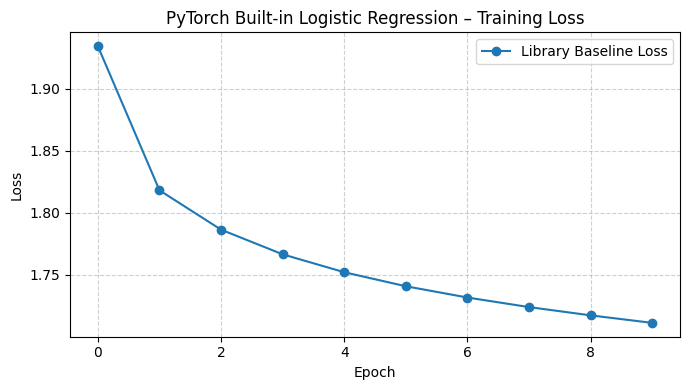

In [35]:
plt.figure(figsize=(7,4))
plt.plot(bl.history, marker='o', label='Library Baseline Loss')
plt.title("PyTorch Built-in Logistic Regression – Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

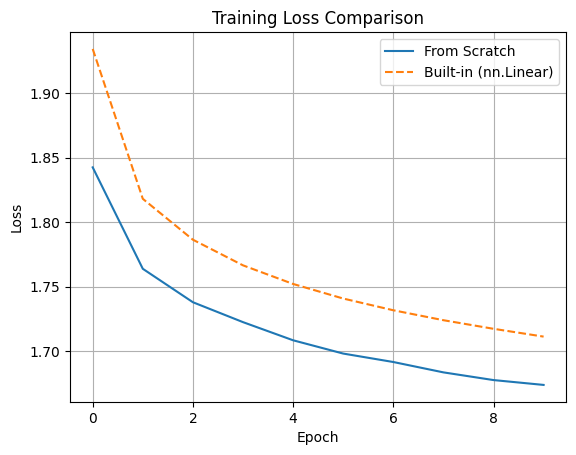

In [36]:
plt.plot(model.history, label="From Scratch")
plt.plot(bl.history, label="Built-in (nn.Linear)", linestyle='--')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()